In [2]:
import numpy as np
import pandas as pd
import regex
import nltk
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense,Input,Dropout,Embedding,LSTM
from time import time
import pickle
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
import  matplotlib.pyplot as plt

In [5]:
with open("Flickr8k_text/Flickr8k.token.txt") as f:
    captions = f.read()

In [6]:
captions = captions.split("\n")[:-1]

In [7]:
len(captions)
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [8]:
descriptions = {}

for element in captions:
    i_to_c = element.split("\t")
    cap = i_to_c[1]
    
    key = i_to_c[0].split(".")[0]
    
    if descriptions.get(key) == None:
        descriptions[key] = []
        
    descriptions[key].append(cap)

In [9]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Data Cleaning

In [10]:
"""
1. lower
2. remove puntuations
3. remove words less than length 2
"""

def clean_text(sample):
    sample = sample.lower()
    sample = regex.sub("[^a-z]+"," ", sample)
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample


In [11]:
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        descriptions[key][i] = clean_text(desc_list[i])

In [12]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
# create unique vocabulary

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]
    
print(len(vocabulary))

8424


In [14]:
all_vocab = []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]
    
print(len(all_vocab))

373837


In [15]:
import collections

In [16]:
counter = collections.Counter(all_vocab)

In [17]:
dict_ = dict(counter)

In [18]:
sorted_dic = sorted(dict_.items(),reverse=True,key = lambda x : x[1])
threshhold_val = 10
sorted_dic = [x for x in sorted_dic if x[1]>threshhold_val]
vocabulary = [x[0] for x in sorted_dic]

In [19]:
len(vocabulary)

1845

# Load Training Testing Data

In [21]:
with open("Flickr8k_text/Flickr_8k.trainImages.txt") as f:
    train = f.read()
with open("Flickr8k_text/Flickr_8k.testImages.txt") as f:
    test = f.read()

In [22]:
train = [e.split(".")[0] for e in train.split("\n")[:-1]]
test = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [23]:
train_descriptions = {}
for t in train:
    train_descriptions[t] = []
    
    for cap in descriptions[t]:
        cap_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_append)

In [24]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Data Preprocessing

In [25]:
model = ResNet50(weights = "imagenet",input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
model_new = Model(inputs = model.input,outputs=model.layers[-2].output)

In [27]:
images = "Images/"

In [28]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    
    return img

In [29]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img).reshape((2048,))
    return feature_vector

In [30]:
x = encode_image(images+"/1000268201_693b08cb0e.jpg")

In [31]:
x.shape

(2048,)

In [32]:
start = time()

encoding_train = {}

for ix,img_ in enumerate(train):
    
    img = images+img_+".jpg"
    
    encoding_train[img] = encode_image(img)
    
    if ix%100 ==0:
        print("encoding image "+str(ix),end="\r")
    


In [33]:
# writing pkl file on disk
with open("encoded_train_images.pkl", "wb") as p:
    pickle.dump(encoding_train,p)

In [34]:
#reading pkl file from disk
with open("encoded_train_images.pkl", "rb") as p:
    encoding_train = pickle.load(p)

In [35]:
start = time()

encoding_test = {}

for ix,img_ in enumerate(test):
    
    img = images+img_+".jpg"
    
    encoding_test[img] = encode_image(img)
    
    if ix%100 ==0:
        print("encoding image "+str(ix),end="\r")
    


In [36]:
# writing pkl file on disk
with open("encoded_test_images.pkl", "wb") as p:
    pickle.dump(encoding_test,p)

In [37]:
#reading pkl file from disk
with open("encoded_test_images.pkl", "rb") as p:
    encoding_test = pickle.load(p)

# Data Preprocessing Captions

In [38]:
# Mapping word_to_idx and idx_to_word

ix = 1
word_to_idx = {}
idx_to_word = {}

for e in vocabulary:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix+=1

In [39]:
word_to_idx['dog']

6

In [40]:
idx_to_word[1846] = "startseq"
word_to_idx["startseq"] = 1846

idx_to_word[1847] = "endseq"
word_to_idx["endseq"] = 1847

In [41]:
vocab_size = len(idx_to_word) +1
print(vocab_size)

1848


In [42]:
all_caption_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_caption_len.append(len(cap.split()))
        
max_len = max(all_caption_len)
print(max_len)

35


## Data Prepare using Generator

In [43]:
def data_generator(train_descriptions,encoding_train,word_to_idx, max_len,num_photos_per_batch):
    x1,x2,y = [],[],[]
    n=0
    while True:
        for key, desc_list in train_descriptions.items():
            n+=1
            photo = encoding_train[images+key+".jpg"]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    in_seq = pad_sequences([in_seq],maxlen=max_len,value=0,padding="post")[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[np.array(x1),np.array(x2)],np.array(y)]
                x1,x2,y =[],[],[]
                n=0
                

# Word Embedding

In [44]:
with open("glove.6B.50d.txt",encoding="utf8") as f:
    embedding_index={}
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype="float")
        embedding_index[word] = coefs

In [45]:
def get_embedding_output():
    em_dim = 50
    
    embedding_output = np.zeros((vocab_size, em_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
    return embedding_output

In [46]:
embedding_output = get_embedding_output()

In [47]:
embedding_output.shape

(1848, 50)

In [48]:
print(embedding_output)

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.33042   0.24995  -0.60874  ... -0.50703  -0.027273 -0.53285 ]
 [ 0.418     0.24968  -0.41242  ... -0.18411  -0.11514  -0.78581 ]
 ...
 [-0.34126  -0.06117   0.93339  ... -0.5682   -0.6244    0.30874 ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]]


# Model Arch

In [49]:
# image feature extractor model
input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation="relu")(inp_img1)

In [50]:
# partial caption sequence model
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [51]:
# combining both models

decoder = add([inp_img2,inp_cap3])
decoder1 = Dense(256,activation="relu")(decoder)
output = Dense(vocab_size,activation="softmax")(decoder1)

In [52]:
model = Model(inputs = [input_img_fea,inp_cap],outputs = output)

In [53]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [54]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [55]:
model.compile(loss="categorical_crossentropy", optimizer = "adam")

# Training

In [56]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [57]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train,word_to_idx,max_len,number_pics_per_batch)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps)
    model.save("model_"+str(i)+".h5")

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
2000/2000 [==============================] - 460s 230ms/step - loss: 4.2968
Epoch 1/1
2000/2000 [==============================] - 476s 238ms/step - loss: 3.5751
Epoch 1/1
2000/2000 [==============================] - 479s 240ms/step - loss: 3.3183
Epoch 1/1
2000/2000 [==============================] - 479s 240ms/step - loss: 3.1615
Epoch 1/1
2000/2000 [==============================] - 480s 240ms/step - loss: 3.0524
Epoch 1/1
2000/2000 [==============================] - 499s 249ms/step - loss: 2.9647
Epoch 1/1
2000/2000 [==============================] - 547s 273ms/step - loss: 2.8942
Epoch 1/1
2000/2000 [==============================] - 523s 261ms/step - loss: 2.8384
Epoch 1/1
2000/2000 [==============================] - 500s 250ms/step - loss: 2.7928
Epoch 1/1
2000/2000 [==============================] - 520s 260ms/step - loss: 2.7536


In [90]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train,word_to_idx,max_len,number_pics_per_batch)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps)
    model.save("model_"+str(i)+".h5")

Epoch 1/1
1000/1000 [==============================] - 457s 457ms/step - loss: 2.6915
Epoch 1/1
1000/1000 [==============================] - 546s 546ms/step - loss: 2.6519
Epoch 1/1
1000/1000 [==============================] - 480s 480ms/step - loss: 2.6264
Epoch 1/1
1000/1000 [==============================] - 468s 468ms/step - loss: 2.6014
Epoch 1/1
1000/1000 [==============================] - 472s 472ms/step - loss: 2.5784
Epoch 1/1
1000/1000 [==============================] - 467s 467ms/step - loss: 2.5566
Epoch 1/1
1000/1000 [==============================] - 471s 471ms/step - loss: 2.5356
Epoch 1/1
1000/1000 [==============================] - 693s 693ms/step - loss: 2.5184
Epoch 1/1
1000/1000 [==============================] - 705s 705ms/step - loss: 2.5005
Epoch 1/1
1000/1000 [==============================] - 690s 690ms/step - loss: 2.4876


In [91]:
#model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_descriptions)//number_pics_per_batch

In [92]:
model.save_weights('model_.h5')

# Prediction

In [93]:
from pickle import load
images = 'Images/'
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)
    
def Search(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

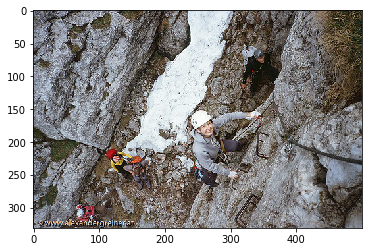

Output: climber scales steep rock face


In [114]:
#z+=1
pic = list(encoding_test.keys())[31]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(pic)
plt.imshow(x)
plt.show()
print("Output:",Search(image))